In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sktime.transformations.compose import FitInTransform
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sktime.transformations.panel.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os

In [2]:
df = pd.read_csv('dataset filtrato salsa e heavy metal.csv')

In [11]:
df = df.drop(columns = 'Unnamed: 0')

In [5]:
classes = df['classes']

In [7]:
classes = np.array(classes)


In [12]:
df = df.drop(columns = 'classes')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df,classes, test_size = 0.3, random_state = 42, stratify = classes)

In [17]:
scaler = StandardScaler()

In [18]:
scaler.fit(X_train)

StandardScaler()

In [20]:
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.fit_transform(X_test)

In [22]:
from sktime.classification.deep_learning import CNNClassifier
import tensorflow as tf
from tensorflow import keras 


In [23]:
cnn = CNNClassifier(
    n_epochs=1000,
    batch_size=16,
    n_conv_layers=2,
    metrics=["accuracy"],
    random_state=42,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor="loss")],
)

In [24]:
cnn.fit(X_train_scaled,y_train)


CNNClassifier(callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x17503a1d0>],
              metrics=['accuracy'], n_epochs=1000, random_state=42)

In [25]:
cnn.score(X_test_scaled, y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


0.5533333333333333

In [30]:
from sktime.classification.kernel_based import RocketClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [29]:
clf = RocketClassifier(num_kernels=500)
clf.fit(X_train_scaled, y_train)

RocketClassifier(num_kernels=500)

In [31]:


y_pred = clf.predict(X_test_scaled)


conf_matrix = confusion_matrix(y_test, y_pred)

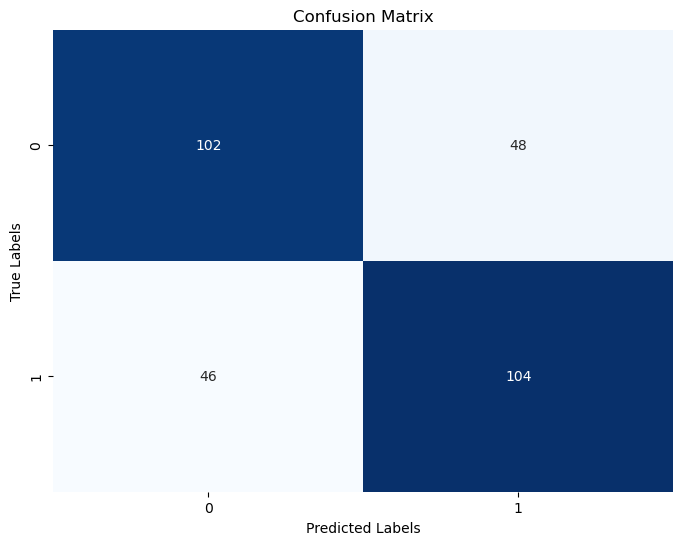

In [33]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [34]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

 heavy-metal       0.69      0.68      0.68       150
       salsa       0.68      0.69      0.69       150

    accuracy                           0.69       300
   macro avg       0.69      0.69      0.69       300
weighted avg       0.69      0.69      0.69       300



In [ ]:
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

 heavy-metal       0.69      0.68      0.68       150
       salsa       0.68      0.69      0.69       150

    accuracy                           0.69       300
   macro avg       0.69      0.69      0.69       300
weighted avg       0.69      0.69      0.69       300



In [46]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sktime.transformations.panel.rocket import Rocket
from sklearn.pipeline import Pipeline
param_grid = {
    'num_kernels': [1000, 5000, 10000],
    'rocket_transform': ['rocket', 'minirocket']  # esempio di parametri da ottimizzare
}

In [ ]:
rocket = Rocket()
rocket_classifier = RocketClassifier()

# define pipeline
pipeline = Pipeline([
    ('rocket', rocket),
    ('classifier', rocket_classifier)
])

In [ ]:
# parameter tuning 

grid_search = GridSearchCV(estimator= rocket_classifier , param_grid=param_grid, cv=3,  verbose=2)


In [48]:
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ..........num_kernels=1000, rocket_transform=rocket; total time=   1.4s
[CV] END ..........num_kernels=1000, rocket_transform=rocket; total time=   1.5s
[CV] END ..........num_kernels=1000, rocket_transform=rocket; total time=   1.8s
[CV] END ......num_kernels=1000, rocket_transform=minirocket; total time=   5.2s
[CV] END ......num_kernels=1000, rocket_transform=minirocket; total time=   0.3s
[CV] END ......num_kernels=1000, rocket_transform=minirocket; total time=   0.3s
[CV] END ..........num_kernels=5000, rocket_transform=rocket; total time=   8.1s
[CV] END ..........num_kernels=5000, rocket_transform=rocket; total time=   8.2s
[CV] END ..........num_kernels=5000, rocket_transform=rocket; total time=   8.1s
[CV] END ......num_kernels=5000, rocket_transform=minirocket; total time=   1.3s
[CV] END ......num_kernels=5000, rocket_transform=minirocket; total time=   1.2s
[CV] END ......num_kernels=5000, rocket_transform

GridSearchCV(cv=3, estimator=RocketClassifier(),
             param_grid={'num_kernels': [1000, 5000, 10000],
                         'rocket_transform': ['rocket', 'minirocket']},
             verbose=2)

In [49]:
best_parameters = grid_search.best_params_

In [50]:
print('best parameters for rocketclassifier are: {}'.format(best_parameters))

best parameters for rocketclassifier are: {'num_kernels': 10000, 'rocket_transform': 'rocket'}


In [51]:
rocket_cfl = RocketClassifier(num_kernels=10000, rocket_transform = 'rocket')


In [53]:
rocket_cfl.fit(X_train_scaled,y_train)

RocketClassifier()

In [54]:
y_predicted = rocket_cfl.predict(X_test_scaled)

In [55]:
print ('the classification report for rocket classifier with hyperparameter tuning is \n', classification_report(y_test,y_predicted))

the classification report for rocket classifier with hyperparameter tuning is 
               precision    recall  f1-score   support

 heavy-metal       0.70      0.71      0.70       150
       salsa       0.70      0.69      0.70       150

    accuracy                           0.70       300
   macro avg       0.70      0.70      0.70       300
weighted avg       0.70      0.70      0.70       300



In [57]:
from sktime.classification.shapelet_based import MrSEQL

In [59]:
!pip install mrseql

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.4/146.4 kB 2.7 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mrseql: filename=mrseql-0.0.2-cp310-cp310-macosx_11_0_arm64.whl size=129444 sha256=f4dbeae1d70c4bc822317b0ae74704646d79f2ab7ca2ac622912d7d3bc052cea
  Stored in directory: /Users/thomasgonzo/Library/Caches/pip/wheels/b9/b1/4f/7b48feae66082015479298644876eb75461bddb1fac91daa56
Successfully built mrseql


In [60]:
seql = MrSEQL(symrep = 'sax')

In [61]:
seql.fit(X_train_scaled,y_train)

MrSEQL()

In [62]:
y_pred_seql = seql.predict(X_test_scaled)

In [63]:
print('classification report for MrSEQL\n', classification_report(y_test,y_pred_seql ))

classification report for MrSEQL
               precision    recall  f1-score   support

 heavy-metal       0.59      0.60      0.59       150
       salsa       0.59      0.58      0.59       150

    accuracy                           0.59       300
   macro avg       0.59      0.59      0.59       300
weighted avg       0.59      0.59      0.59       300



In [64]:
seql2 = MrSEQL(seql_mode = 'clf', symrep = 'sax')

In [65]:
seql2.fit(X_train_scaled, y_train)

MrSEQL(seql_mode='clf')

In [66]:
y_pred_seql2 = seql2.predict(X_test_scaled)

In [67]:
print('classification report for MrSEQL\n', classification_report(y_test,y_pred_seql2 ))

classification report for MrSEQL
               precision    recall  f1-score   support

 heavy-metal       0.50      1.00      0.67       150
       salsa       0.00      0.00      0.00       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300



/Users/thomasgonzo/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thomasgonzo/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thomasgonzo/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
